Populating the interactive namespace from numpy and matplotlib
3756


`%matplotlib` prevents importing * from pylab and numpy


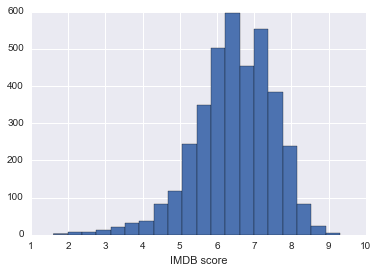

Minimum Square Error 

C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

0    0.013732
dtype: float64
R-Square: 0.297677370148
correlation with director_facebook_likes is: 0.192313548643
correlation with gross is: 0.214739712176
correlation with num_voted_users is: 0.482429606479
correlation with num_critic_for_reviews is: 0.347885638604
correlation with num_user_for_reviews is: 0.325002592496
correlation with budget is: 0.0291897224546
correlation with movie_facebook_likes is: 0.281154991472
correlation with duration is: 0.366221017357
correlation with actor_3_facebook_likes is: 0.0655436116815
correlation with actor_1_facebook_likes is: 0.0935971797263
correlation with actor_2_facebook_likes is: 0.102372039041
correlation with cast_total_facebook_likes is: 0.106802526649
correlation with facenumber_in_poster is: -0.0654926113212
correlation with profit is: 0.0369819844511
In the movie data, 642 out of 3756 directors_facebook_like are 0
In the movie data, 1742 out of 3756 movie_facebook_like are 0
Minimum Square Error with few numeric 0    0.012694
dtype: 

C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.143e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 8.689e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=9.870e-04, with an active set of 37 regressors, and the smallest cholesky pivot element being 3.650e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=8.537e-04, with an active set of 47 regressors, and the smallest cholesky pivot element being 4.470e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: Conve

0.00038422216645
Rsq Lasso:  0.440971247916
CV score for LASSO:  0.40024119033
CV score for RF:  0.507358059293
R square for RF:  0.542021764496
['num_voted_users', u'genres_drama', 'budget', 'duration', 'gross', 'num_user_for_reviews', 'num_critic_for_reviews', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'director_facebook_likes']


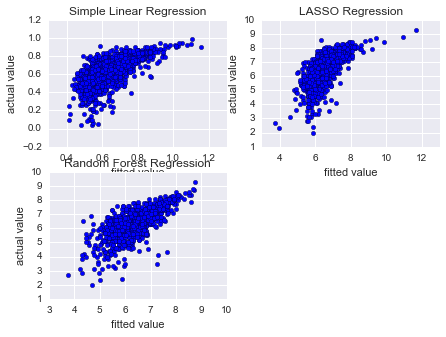

In [9]:
#Author - Soujanya

import pandas as pd
import matplotlib.pyplot as plt
import Preprocessor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target

%pylab inline
#Reading from csv and Cleaning
imdb_movie = Preprocessor.data
imdb_movie['profit'] = imdb_movie['gross'] - imdb_movie['budget']

print len(imdb_movie)

##################################
#Plotting histogram for imdb_score
##################################

imdb_score = imdb_movie['imdb_score']
plt.hist(imdb_score,bins=20)
plt.xlabel('IMDB score')
plt.show()

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

###################
#Correlation Plot
###################
# corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# plt.figure(figsize=(12, 12))
# sns.heatmap(corr, vmax=1, square=True)
# plt.show()


xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

###########################################
#First step: Using Simple Linear Regression
###########################################

model = LinearRegression()
model.fit(xtrain,ytrain)
pred = model.predict(xtest)
mse = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error', mse
print 'R-Square:', model.score(xtest,ytest)

###############
# Scatter plots
###############

# plt.figure(figsize=(7,10))
# for i in range(len(list_fig)):
#     plt.subplot(8,2,i+1)
#     plt.title(list_fig[i])
#     plt.scatter(target,data[list_fig[i]],marker='x',color='r',label='dir_score')    
# plt.tight_layout()
# plt.show()

for i in list_fig:
    corre = np.corrcoef(imdb_movie[i],imdb_movie['imdb_score'])
    print 'correlation with', i , 'is:', corre[0][1]

#------------------------------------------------
imdb_movie_dir = imdb_movie[imdb_movie['director_facebook_likes']==0]
print 'In the movie data,',imdb_movie_dir.shape[0],'out of', imdb_movie.shape[0],'directors_facebook_like are 0'

imdb_movie_ml = imdb_movie[imdb_movie['movie_facebook_likes']==0]
print 'In the movie data,',imdb_movie_ml.shape[0],'out of', imdb_movie.shape[0],'movie_facebook_like are 0'

#############################################
#Second Step: Removing Few Numerical Features
#############################################

remove_list = ['director_facebook_likes','movie_facebook_likes']
for rm in remove_list:
    list_fig.remove(rm)

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

model_2 = LinearRegression()
model_2.fit(xtrain,ytrain)
pred = model_2.predict(xtest)
mse2 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with few numeric', mse2
print 'R-Square with few numeric:', model_2.score(xtest,ytest)
    
###############################################
#Third step: Including text/categorical feature
###############################################

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list

xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.5)

model_3 = LinearRegression()
model_3.fit(xtrain,ytrain)
pred = model_3.predict(xtest)
mse3 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with numeric+text', mse3
print 'R-Square with numeric+text:', model_3.score(xtest,ytest)

plt.figure(figsize=(7,5))

plt.subplot(221)
plt.scatter(pred , ytest)
plt.title("Simple Linear Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")

####################################
#Using LASSO Regression
####################################

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

# data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
# targetcol = 'imdb_score'

# data,target = scaler(data,target)

data = imdb_movie[list_fig]
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
target = imdb_movie['imdb_score']

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['director_name'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list


xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

aic_m = LassoLarsIC(criterion='aic')
aic_m.fit(xtrain, ytrain)
alphas_ = aic_m.alphas_
criterion_ = aic_m.criterion_
# plt.subplot(224)
# plt.plot(-np.log10(alphas_), criterion_, '--', color='b',
#              linewidth=3)
# plt.show()
print aic_m.alpha_

model_L = Lasso(alpha=aic_m.alpha_)
model_L.fit(xtrain,ytrain)
ypred = model_L.predict(xtest)
score = cross_val_score(model_L, new_data, target,cv=5)
mse2 = (np.mean((ypred - ytest) ** 2))
rsq = model_L.score(xtest,ytest)

print 'Rsq Lasso: ', rsq
print 'CV score for LASSO: ',np.mean(score)

########################################
#Using Random Forest Regression
########################################

rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
scores = cross_val_score(rf,new_data,target,cv=5)
print 'CV score for RF: ',np.mean(scores)
pred_rf = rf.predict(xtest)
mse4 = np.mean((pred_rf - ytest) ** 2)
rsq1 = rf.score(xtest,ytest)
print 'R square for RF: ', rsq1


plt.subplot(222)
plt.scatter(ypred,ytest)
plt.title("LASSO Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")

plt.subplot(223)
plt.scatter(pred_rf, ytest)
plt.title("Random Forest Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")


#####################################
#Find to 10 predictors
#####################################
indices = np.argsort(rf.feature_importances_)[::-1]
top10 = indices[0:10]

f=[]
for i in top10:
    f.append(new_coeff_list[i])
    
    
print f


In [14]:
# Author: Sayma Akther
# Classification of profitable movie, if gross is greater than budget

import pandas
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np

import time
import Preprocessor
import Evaluator


def numerical_to_binary(y, cut_off):    
	y.iloc[[i for i,v in enumerate(y) if v >= cut_off]]=1
	y.iloc[[i for i,v in enumerate(y) if v < cut_off]]=0
	return y

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target


data = pandas.read_csv('movie_metadata.csv')
features_allnum = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_user_for_reviews', 'imdb_score', 'budget', 'title_year', 'aspect_ratio', 'movie_facebook_likes']
features_x = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_user_for_reviews', 'budget', 'title_year', 'aspect_ratio', 'movie_facebook_likes']
feature_y = 'gross'
list_fig = ['director_facebook_likes','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster']
data = Preprocessor.data
data['profit'] = data['gross'] - data['budget']

x, y = Preprocessor.getX_y(feature_y, features_allnum)
# x,y = scaler(x,y)
y = data['profit']
print("Classification of profitable movie, if gross is greater than budget")

cut_off = 0
y=numerical_to_binary(y, cut_off)
Evaluator.evaluateClassification(x, y, 0.5)
Evaluator.crossvalidationClassification(x, y)

# Adding text features
vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(data['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(data['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(data['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

x_all = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])

print('-----------------------Numerical + categorical features----------------------------------------')
Evaluator.evaluateClassification(x_all, y, 0.5)
Evaluator.crossvalidationClassification(x_all, y)


Classification of profitable movie, if gross is greater than budget
------------Logistic regrassion  l2
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       1.00      1.00      1.00       896\n        1.0       1.00      1.00      1.00       982\n\navg / total       1.00      1.00      1.00      1878\n')
------------Logistic regrassion  l1


C:\Users\schttrj1\AppData\Roaming\Python\Python27\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       1.00      1.00      1.00       896\n        1.0       1.00      1.00      1.00       982\n\navg / total       1.00      1.00      1.00      1878\n')
------------Decision Tree method
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       0.97      0.96      0.96       896\n        1.0       0.96      0.97      0.97       982\n\navg / total       0.96      0.96      0.96      1878\n')
------------Extra Trees method
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       0.87      0.86      0.86       896\n        1.0       0.87      0.88      0.88       982\n\navg / total       0.87      0.87      0.87      1878\n')
------------Random Forest method
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       0.92      0.90      0.91       896\n    

In [16]:
# Author: Sayma Akther
# Classification of High rated movie, if IMDB rating greater than 8

import pandas
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np

import time
import Preprocessor
import Evaluator


def numerical_to_binary(y, cut_off):
	y.iloc[[i for i,v in enumerate(y) if v < cut_off]]=0
	y.iloc[[i for i,v in enumerate(y) if v >= cut_off]]=1
	return y

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target


data = pandas.read_csv('movie_metadata.csv')
features_allnum = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_user_for_reviews', 'imdb_score', 'budget', 'title_year', 'aspect_ratio', 'movie_facebook_likes']
features_x = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_user_for_reviews', 'budget', 'title_year', 'aspect_ratio', 'movie_facebook_likes']
feature_y = 'imdb_score'
list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']
data = Preprocessor.data
data['profit'] = data['gross'] - data['budget']

x, y = Preprocessor.getX_y(feature_y, features_allnum)
# x,y = scaler(x,y)
print("Classification of High rated movie, if IMDB rating greater than 8")

cut_off = 8
y=numerical_to_binary(y, cut_off)
Evaluator.evaluateClassification(x, y, 0.5)
Evaluator.crossvalidationClassification(x, y)


# Adding text features
print('-----------------------Numerical + categorical features----------------------------------------')
vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(data['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(data['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(data['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

x_all = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])

Evaluator.evaluateClassification(x_all, y, 0.5)
Evaluator.crossvalidationClassification(x_all, y)


Classification of High rated movie, if IMDB rating greater than 8
------------Logistic regrassion  l2
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       0.95      0.99      0.97      1775\n        1.0       0.57      0.12      0.19       103\n\navg / total       0.93      0.95      0.93      1878\n')
------------Logistic regrassion  l1
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       1.00      1.00      1.00      1775\n        1.0       0.99      0.92      0.95       103\n\navg / total       1.00      1.00      1.00      1878\n')
------------Decision Tree method
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       1.00      1.00      1.00      1775\n        1.0       1.00      1.00      1.00       103\n\navg / total       1.00      1.00      1.00      1878\n')
------------Extra Trees method
('Classification Report:\n', '         

C:\Python27\Lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Python27\Lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


('vectorization Precision=', 0.47000000000000003)
('vectorization Recall=', 0.10265780730897012)
('vectorization F1=', 0.14516038711042739)
------------Logistic regrassion  l1
('vectorization Precision=', 0.9507996068971678)
('vectorization Recall=', 0.91539313399778521)
('vectorization F1=', 0.92466629790323418)
------------GaussianNaiveBayes method
('vectorization Precision=', 0.32887901572112099)
('vectorization Recall=', 0.32314507198228132)
('vectorization F1=', 0.24392397408261948)
-----------------------Numerical + categorical features----------------------------------------
------------Logistic regrassion  l2
('Classification Report:\n', '             precision    recall  f1-score   support\n\n        0.0       0.97      0.94      0.95      1764\n        1.0       0.34      0.50      0.40       114\n\navg / total       0.93      0.91      0.92      1878\n')
------------Logistic regrassion  l1
('Classification Report:\n', '             precision    recall  f1-score   support\n\n